In [0]:
!pip install transformers
!pip install --upgrade tensorflow
# !pip install bert
# !pip list

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend

# Used for Huggingface Transformers
import transformers as trans

# Used for TFHub
# import bert
# import tensorflow_hub as hub
# from tqdm import tqdm_notebook

In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
  local_device_protos = device_lib.list_local_devices()
  return[x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


## Data Prep

In [0]:
# Read articles and Ratings file

# df_articles_train  = pd.read_csv('Data/latest/articles_train.csv')
# df_articles_test  = pd.read_csv('Data/latest/articles_test.csv')

latest_train_url = 'https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv'
latest_test_url  = 'https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv'

df_articles_train  = pd.read_csv(latest_train_url)
df_articles_test   = pd.read_csv(latest_test_url)

X_train = df_articles_train['content_body_clean'].to_frame()
y_train = df_articles_train['blind_mean_rating'].to_frame()

X_test = df_articles_test['content_body_clean'].to_frame()
y_test = df_articles_test['blind_mean_rating'].to_frame()

## Huggingface Transformers

### Tokenize

In [0]:
def _get_segments(sentences):
    sentences_segments = []
    for sent in sentences:
      temp = []
      i = 0
      for token in sent.split(" "):
        temp.append(i)
        if token == "[SEP]":
          i += 1
      sentences_segments.append(temp)
    return sentences_segments

def _get_inputs(df,_maxlen,tokenizer):

    max_index = np.int((_maxlen-20)/2)
    # max_index = np.int(_maxlen - 1)
    pattern = '[^\w\s]+|\n' # remove everything including newline (|\n) other than words (\w) or spaces (\s)
    special_tokens_cnt = 2  # [CLS], [SEP]
  
    sentences = ["[CLS] " + " ".join(tokenizer.tokenize(text)[:max_index]) +" [SEP] " 
                # for (text) in (df['content_body_clean'].str.replace(pattern, '').values.tolist())
                for (text) in (df['content_body_clean'].values.tolist())                
                ]

    # Generate Masks
    # BERT requires a mask for the words which are padded. 
    sentences_mask = [[1]*len(sent.split(" "))+[0]*(_maxlen + special_tokens_cnt - len(sent.split(" "))) for sent in sentences]
 
    # Generate Padded/Input IDs  
    # If less than max length provided then the words are padded
    sentences_padded = [sent + " [PAD]"*(_maxlen + special_tokens_cnt - len(sent.split(" "))) if len(sent.split(" ")) < _maxlen + special_tokens_cnt else sent for sent in sentences ]
    sentences_converted = [tokenizer.convert_tokens_to_ids(s.split(" ")) for s in sentences_padded] 

    # Generate Segments
    # For each separation [SEP], a new segment is converted
    sentences_segment = _get_segments(sentences_padded)

    # DEBUGGING

    # for sent in sentences:
    #   if len(sent.split(" ")) < _maxlen +2:
    #     print ("Index")
    #     print(sentences.index(sent))
    #     print(len(sent.split(" ")))

    # for sent in sentences_padded:
    #   if len(sent.split(" ")) != _maxlen+2:
    #     print ("Index: ", sentences_padded.index(sent))
    #     print(len(sent.split(" ")))

    # 48, 701
    # test_index = 71

    # genLength1 = set([len(sent.split(" ")) for sent in sentences])
    # print("Sentence Set: ", genLength1)
    # print(len(genLength1))

    # print("Actual")
    # print(sentences[test_index])
    # print(len(sentences[test_index].split(" ")))

    # print("Masked")
    # print(sentences_mask[test_index])
    # print(len(sentences_mask[test_index])) 

    # print("Padded")
    # print(sentences_padded[test_index])
    # print(len(sentences_padded[test_index].split(" ")))

    # print("Converted")
    # print(sentences_converted[test_index])
    # print(len(sentences_converted[test_index]))   
    
    # print(sentences[0])
    # print(sentences_segment[0])
    
    # Confirm all sentences are of same length
    genLength = set([len(sent.split(" ")) for sent in sentences_padded])

    if len(genLength)!=1: 
      print(genLength)
      raise Exception("sentences are not of same size")

    # Convert list into tensor integer arrays and return it
    return [tf.cast(sentences_converted,tf.int32), 
            tf.cast(sentences_segment,tf.int32), 
            tf.cast(sentences_mask,tf.int32)]


### Pre-trained model using Transformer

In [6]:
bert_model_type = 'bert-base-uncased'
# bert_model_type = 'bert-large-uncased' 
# bert_model_type = 'bert-base-cased' 
# bert_model_type = 'bert-large-cased'

bert_tokenizer_transformer = trans.BertTokenizer.from_pretrained(bert_model_type, do_lower_case=True)
bert_model = trans.TFBertModel.from_pretrained(bert_model_type)

In [0]:
max_sequence_length = 256

In [0]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# bert_inputs_val = _get_inputs(df=X_val, tokenizer=bert_tokenizer_transformer, _maxlen=max_sequence_length)
# Xtr_val = bert_inputs_val
# ytr_val = np.asarray(y_val)

In [9]:
bert_inputs_train = _get_inputs(df=X_train, tokenizer=bert_tokenizer_transformer, _maxlen=max_sequence_length)
bert_inputs_test  = _get_inputs(df=X_test,  tokenizer=bert_tokenizer_transformer, _maxlen=max_sequence_length)

Xtr = bert_inputs_train
ytr = np.asarray(y_train)

Xte = bert_inputs_test
yte = np.asarray(y_test)

[CLS] hundreds of thousands of americans across puerto rico and the us virgin islands rang in the new year in darkness , still mir ##ed in the longest blackout in us history . it ’ s been more than 100 days since hurricane maria ravaged the electrical grid ##s of these two us territories , but 14 , 81 ##5 utility customers in the us virgin islands , more than a quarter of the total customers , still don ’ t have electricity . in puerto rico , 67 ##5 , 000 customers , or 43 percent of the total , lack power . the blackout stemming from hurricane maria was already the longest in us history back in [SEP] 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Model

In [8]:
#reference: https://github.com/huggingface/transformers

inputs_length = max_sequence_length + 2

token_inputs = Input((inputs_length), dtype=tf.int32, name='input_word_ids')
mask_inputs = Input((inputs_length), dtype=tf.int32, name='input_masks')
seg_inputs = Input((inputs_length), dtype=tf.int32, name='input_segments')

seq_output,_ = bert_model([token_inputs, mask_inputs, seg_inputs])
X = GlobalAveragePooling1D()(seq_output)
X = Dense(100, activation='relu')(X)
output_= Dense(1, activation='linear', name='output')(X)
# output_= Dense(1, activation=None, name='output')(X)

bert_model2 = Model([token_inputs, mask_inputs, seg_inputs],output_)
bert_model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 258)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 258)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 258)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 258, 768), ( 109482240   input_word_ids[0][0]             
                                                                 input_masks[0][0]            

In [0]:
lr = 0.0001  ## 0.1, 0.01, 0.001, 2e-5 
opt = tf.keras.optimizers.Adam(learning_rate=lr)

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

bert_model2.compile(optimizer=opt, loss='mse', metrics=['mae', rmse])
 
# bert_model2.compile(optimizer='Adam', loss='mse', metrics=['mae', rmse])

# Callbacks
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11, verbose=0, mode='min')
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

# class PredictionCallback(tf.keras.callbacks.Callback):    
#   def on_epoch_end(self, epoch, logs={}):
#     y_pred = self.model.predict(self.validation_data[0])
#     print('prediction: {} at epoch: {}'.format(y_pred, epoch))

In [10]:
history = bert_model2.fit(Xtr, ytr, 
                          epochs=25, 
                          validation_split = 0.2,
                          # batch_size = 100,
                          # validation_data=(Xtr_val, ytr_val),
                          verbose = 1
                          # callbacks=[earlyStopping,reduce_lr]
                          # callbacks=[earlyStopping, PredictionCallback()]
                          )

Train on 1040 samples, validate on 261 samples
Epoch 1/25
1040/1040 [==============================] - 50s 48ms/sample - loss: 1.0598 - mae: 0.7876 - rmse: 0.9844 - val_loss: 1.0526 - val_mae: 0.8007 - val_rmse: 1.0037
Epoch 2/25
1040/1040 [==============================] - 35s 33ms/sample - loss: 0.8053 - mae: 0.6736 - rmse: 0.8894 - val_loss: 1.0168 - val_mae: 0.7959 - val_rmse: 0.9920
Epoch 3/25
1040/1040 [==============================] - 35s 33ms/sample - loss: 0.7615 - mae: 0.6559 - rmse: 0.8548 - val_loss: 0.9937 - val_mae: 0.8015 - val_rmse: 0.9889
Epoch 4/25
1040/1040 [==============================] - 35s 33ms/sample - loss: 0.7513 - mae: 0.6503 - rmse: 0.8550 - val_loss: 1.0261 - val_mae: 0.7970 - val_rmse: 0.9946
Epoch 5/25
1040/1040 [==============================] - 35s 33ms/sample - loss: 0.7763 - mae: 0.6613 - rmse: 0.8749 - val_loss: 1.0773 - val_mae: 0.8434 - val_rmse: 1.0417
Epoch 6/25
1040/1040 [==============================] - 34s 33ms/sample - loss: 0.7529 - mae:

In [0]:
test_results = bert_model2.evaluate(Xte, yte)
print('Test MSE: {0:.4f}'.format(test_results[0]))
print('Test MAE: {0:.4f}'.format(test_results[1]))
print('Test RMSE: {0:.4f}'.format(test_results[2]))

326/326 [==============================] - 2s 6ms/sample - loss: 1.0053 - mae: 0.8174 - rmse: 0.9994
Test MSE: 1.0053
Test MAE: 0.8174
Test RMSE: 0.9994


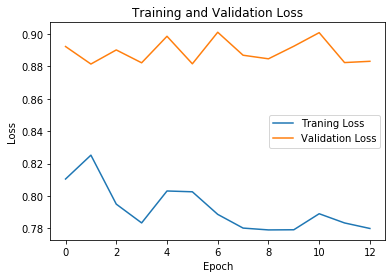

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_loss))

plt.plot(epochs, train_loss, label='Traning Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
y_pred = bert_model2.predict(Xte)
y_pred[:10]

In [0]:
yte[:10]

In [0]:
# y_pred = y_pred.reshape(y_pred.shape[0])
# d = yte - y_pred
# mse_f = np.mean(d**2)
# mae_f = np.mean(abs(d))
# rmse_f = np.sqrt(mse_f)
# # r2_f = 1-(np.sum(d**2)/np.sum((y-np.mean(y))**2))

# print("RESULTS...")
# print("MAE:",mae_f)
# print("MSE:", mse_f)
# print("RMSE:", rmse_f)
# print("R-Squared:", r2_f)

In [0]:
# def plot_history(histories, key='loss'):
#   plt.figure(figsize=(10,8))
    
#   for name, history in histories:
#     val = plt.plot([x+1 for x in history.epoch], history.history['val_'+key],
#                    label='Val_'+key)
#     plt.plot([x+1 for x in history.epoch], history.history[key],
#              label='Train_'+key)

#   plt.xlabel('Epochs')
#   plt.xticks([x+1 for x in history.epoch])
#   plt.ylabel(key.replace('_',' ').title())
#   plt.legend()

#  plot_history([('linear_model', history)]) 

In [0]:
### Fit on test data
plt.plot(yte, y_pred, '.')

# # plot a line, a perfet predict would all fall on this line
x = np.linspace(0, 5)
y = x
plt.plot(x, y)
plt.show()